In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
import torch

2023-10-23 18:05:54.902236: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 18:06:01.023791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    df["headline"]= df.apply(lambda x: x['masked headline'].replace('____', str(x['ans'])), axis=1)
    print(df.iloc[0])
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
    df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [4]:
train_data = json_to_dataframe('Train_Numerical_Reasoning.json')

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object
news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
headline            30K Walmart Part-Timers to Lose Health Insurance
Name: 0, dtype: object


In [5]:
train_data.head()

,news,masked headline,calculation,ans,headline,text
0,"As of Jan. 1, Walmart will no longer offer 30...",<extra_id_0> K Walmart Part-Timers to Lose Hea...,"Paraphrase(30,000,K)",30,30K Walmart Part-Timers to Lose Health Insurance,"As of Jan. 1, Walmart will no longer offer 30..."
1,Dax Shepard and Kristen Bell got married at t...,Dax Shepard: Wedding to Kristen Bell Cost $<ex...,Copy(142),142,Dax Shepard: Wedding to Kristen Bell Cost $142,Dax Shepard and Kristen Bell got married at t...
2,"Nancy Reagan, the helpmate, backstage adviser...",Nancy Reagan Dead at <extra_id_0> </s>,Copy(94),94,Nancy Reagan Dead at 94,"Nancy Reagan, the helpmate, backstage adviser..."
3,American Airlines faces FAA fines of more tha...,American Airlines Faces $<extra_id_0> M Fine f...,Copy(7),7,American Airlines Faces $7M Fine for Safety Vi...,American Airlines faces FAA fines of more tha...
4,"Ingrid Lyne, the Seattle mom allegedly murder...",$<extra_id_0> K Raised for Kids of Mom Dismemb...,"Paraphrase(222,000,K)",222,$222K Raised for Kids of Mom Dismembered on Date,"Ingrid Lyne, the Seattle mom allegedly murder..."


In [6]:
dataset = Dataset.from_pandas(train_data)
dataset = dataset.train_test_split(test_size=0.2)

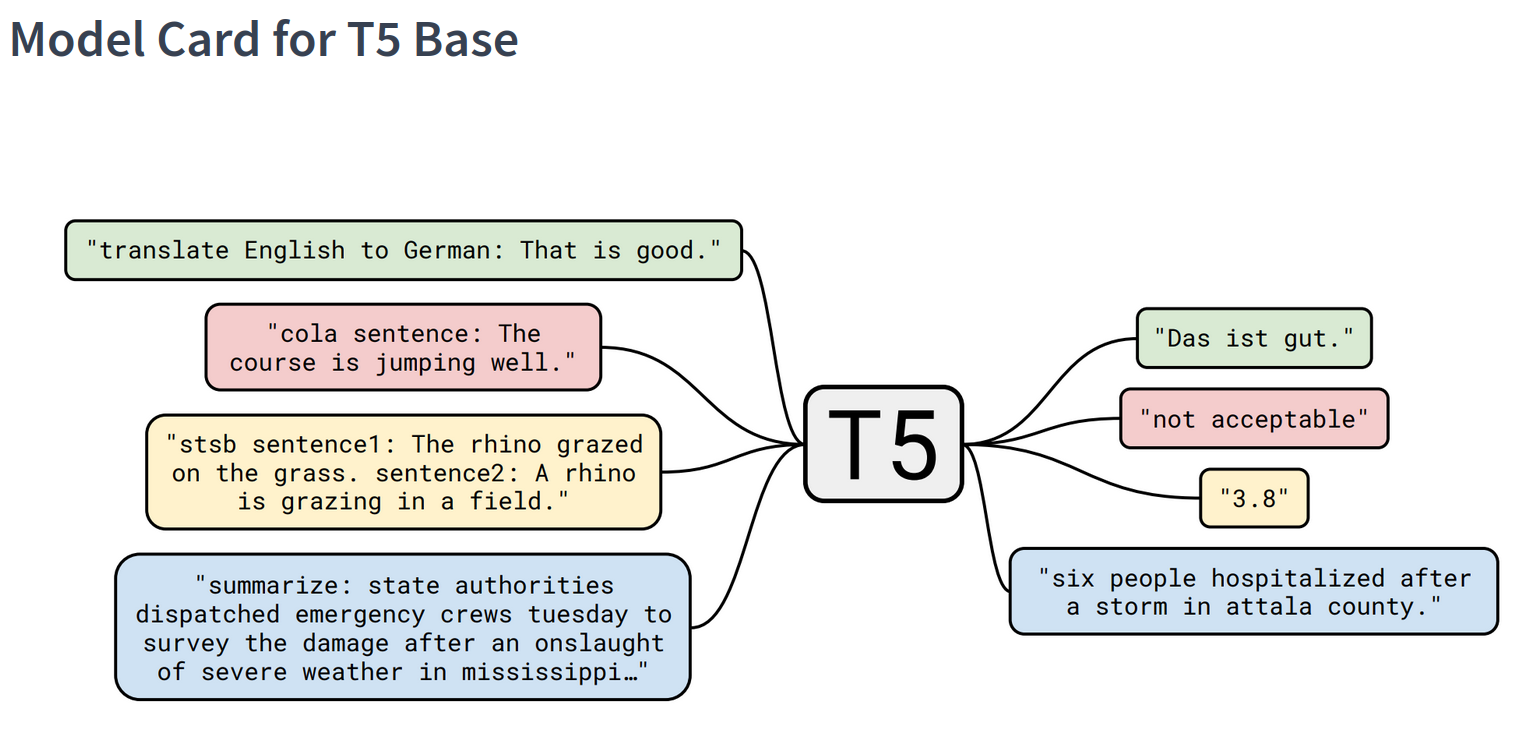

T5 is Text-to-Text-Transfer-Transformer model. It takes input texts for various NLP tasks and outputs the text for that respective task. 

T5 is slightly different from Masked Language Model such as BERT. Masked Language Models are Bidirectional models which use Mask token for each word while T5 replaces multiple consecutive tokens with a single Mask keyword. Since the final objective is to have trained a model that inputs text and outputs text, the targets were designed to produce a sequence, unlike BERT, that tries to output one word (itself). So t5 is suitable for text summarization and headline generation.

In [7]:
model_name ="czearing/article-title-generator"

### The model is based on t5-base and has been trained on a collection of 500k articles with headings. Its purpose is to create a one-line heading suitable for the given article. https://huggingface.co/Michau/t5-base-en-generate-headline

In [6]:
'''
model_names = ["it5/it5-base-headline-generation", 
               "it5/it5-small-headline-generation",
               "it5/mt5-base-headline-generation",
               "it5/mt5-small-headline-generation", 
               "it5/it5-efficient-small-el32-headline-generation",
               "Michau/t5-base-en-generate-headline"]
'''

'\nmodel_names = ["it5/it5-base-headline-generation", \n               "it5/it5-small-headline-generation",\n               "it5/mt5-base-headline-generation",\n               "it5/mt5-small-headline-generation", \n               "it5/it5-efficient-small-el32-headline-generation",\n               "Michau/t5-base-en-generate-headline"]\n'

To prefix the input with a prompt so T5 knows this is a headline generation task

In [8]:
def preprocess_function(examples):   
    #inputs = [prefix + doc for doc in examples["news"]]
    inputs = tokenizer(examples['text'],max_length=2024,  truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=128, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

To apply the preprocess function over the entire dataset

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
tokenized = dataset.map(preprocess_function, batched=True, num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map (num_proc=4):   0%|          | 0/16925 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4232 [00:00<?, ? examples/s]

In [10]:
#tokenized = train_data.map(preprocess_function, batched=True)

To create batches using DataCollatorForSeq2Seq, which dynamically pads the sentences to the longest length in a batch during collation. This is  more efficient than padding the whole dataset to the maximum length. 

In [11]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=1e-4, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)


To load pretrained T5-base michau with AutoModelForSeq2SeqLM

In [12]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)

2023-10-23 18:06:39.830914: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:01:00.0, compute capability: 7.0
2023-10-23 18:06:39.831687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'lm_head.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializin

To convert datasets to the tf.data.Dataset format 

In [13]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
model.compile(optimizer=optimizer)

In [15]:
eval_loss = model.evaluate(tf_test_set)
print(f"Pretrained LM Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 61s 199ms/step - loss: 0.7431
Pretrained LM Perplexity: 2.10


In [15]:
history = model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size = 6, epochs=10)
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/10
1057/1057 [==============================] - 665s 606ms/step - loss: 0.1164 - val_loss: 0.0547
Epoch 2/10
1057/1057 [==============================] - 636s 602ms/step - loss: 0.0592 - val_loss: 0.0481
Epoch 3/10
1057/1057 [==============================] - 635s 601ms/step - loss: 0.0470 - val_loss: 0.0469
Epoch 4/10
1057/1057 [==============================] - 635s 601ms/step - loss: 0.0393 - val_loss: 0.0443
Epoch 5/10
1057/1057 [==============================] - 636s 601ms/step - loss: 0.0347 - val_loss: 0.0456
Epoch 6/10
1057/1057 [==============================] - 635s 601ms/step - loss: 0.0303 - val_loss: 0.0463
Epoch 7/10
1057/1057 [==============================] - 635s 601ms/step - loss: 0.0265 - val_loss: 0.0461
Epoch 8/10
1057/1057 [==============================] - 636s 602ms/step - loss: 0.0238 - val_loss: 0.0477
Epoch 9/10
1057/1057 [==============================] - 634s 600ms/step - loss: 0.0219 - val_loss: 0.0450
Epoch 10/10
1057/1057 [=======================

In [17]:
eval_loss = model.evaluate(tf_test_set)
print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

265/265 [==============================] - 53s 200ms/step - loss: 0.0470
Finetuned Perplexity: 1.05


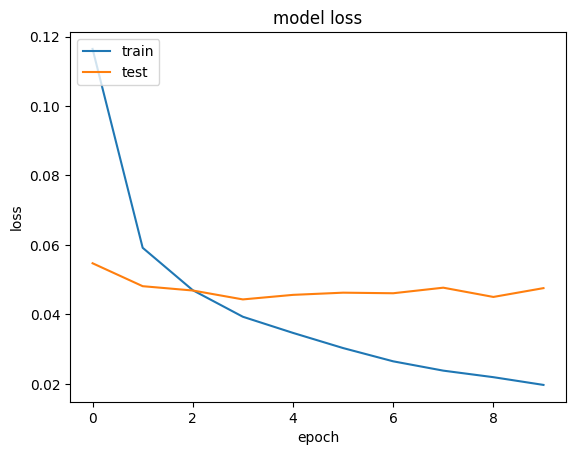

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
#df = df.iloc[:200]
#df = df.iloc[100:500]
f.close()
test_data = Dataset.from_pandas(df)

In [18]:
# Try improved version
def t5_predictions(data, tokenizer, model):
    text = data['text']
    headline = data['masked headline']
    print(headline)
    inputs = tokenizer.encode_plus(text, add_special_tokens=True,
                                   return_tensors="pt").input_ids
    # input_ids = inputs['input_ids'].to(device)
    # attention_masks = inputs['attention_mask']

    outputs = model.generate(inputs,
                             max_length=128, num_beams=5, early_stopping=True)

    _0_index = headline.index('<extra_id_0> ')
    print(_0_index)

    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    print("Pred: ", results)
    #res = re.findall(r"([\d:,./]+)", results)
    res = re.findall(r"(\d+[./]?\d*)", results[_0_index:_0_index+50])
    if len(res) < 1:
        res = re.findall(r"(\d+[./]?\d*)", results)
    try:
        return res[0]
    except:
        return None

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [19]:
tru = 0
for i in test_data:
    prediction1 = t5_predictions(i, tokenizer, model)
    answer = i['ans']
    print("Answer: ", answer)
    print("Prediction1: ", prediction1)
    print("Calc: ", i['calculation'])
    if answer == prediction1:
        tru += 1
    print("")

<extra_id_0> rd Victim Dead in Quarry Shooting; Manhunt Still On </s>


2023-10-23 19:55:28.827811: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1bf5616d20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-23 19:55:28.827881: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-23 19:55:28.827890: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-10-23 19:55:28.834670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-23 19:55:28.878380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-10-23 19:55:28.890405: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

0
Pred:  3rd Victim Dead in Quarry Shooting; Manhunt Still On</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

NYT Corrects 1853 Piece After <extra_id_0>  Years Win </s>
30
Pred:  NYT Corrects 1853 Piece After 12 Years Win</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Stocks Up <extra_id_0>  in Election Rally </s>
10
Pred:  Stocks Up 305 in Election Rally</s>
Answer:  305
Prediction1:  305
Calc:  Round(305.45,0)

You Can Watch The Interview at <extra_id_0> pm </s>
31
Pred:  You Can Watch The Interview at 1pm</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Murder Suspect, <extra_id_0> , Will Stay in Adult Jail </s>
16
Pred:  Murder Suspect, 10, Will Stay in Adult Jail</s><pad>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Tobacco Firms Knew of Radiation in Cigs—in <extra_id_0>  </s>
43
Pred:  Tobacco Firms Knew of Radiation in Cigs—in 1959</s>
Answer:  1959
Prediction1:  1959
Calc:  Copy(1959)

AIG Bonuses Higher Than Thought: $<extra_id_0> M </s>
34
Pred:  AIG Bonuses H

21
Pred:  Ford Surprises With $100M Q1 Profit</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

<extra_id_0>  Students Arrested After Chemical 'Device' Goes Off </s>
0
Pred:  2 Students Arrested After Chemical 'Device' Goes Off</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

<extra_id_0>  Winning Powerball Tickets Sold </s>
0
Pred:  1 Winning Powerball Tickets Sold</s>
Answer:  2
Prediction1:  1
Calc:  Add(Span(Arizona),Span(Missouri))

Humans Push Earth Past <extra_id_0>  of 9 Danger Zones </s>
23
Pred:  Humans Push Earth Past 4 of 9 Danger Zones</s>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Floridian Is Now <extra_id_0> rd to Die of Seawater Bacteria </s>
17
Pred:  Floridian Is Now 3rd to Die of Seawater Bacteria</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Clintons Near Deal on $<extra_id_0> M Country Mansion </s>
23
Pred:  Clintons Near Deal on $11M Country Mansion</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

Periodic Table Gets <extra_id_0>  New Elements

10
Pred:  Bruni to G8: Don't Let Recession Kill AIDS Funding</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Shakespeare Gets a <extra_id_0> -Year-Old Drug Test </s>
19
Pred:  Shakespeare Gets a 400-Year-Old Drug Test</s>
Answer:  400
Prediction1:  400
Calc:  Copy(400)

Elizabeth Edwards Dead at <extra_id_0>  </s>
26
Pred:  Elizabeth Edwards Dead at 61</s>
Answer:  61
Prediction1:  61
Calc:  Copy(61)

New EU Sanctions Hit Maker of AK-<extra_id_0>  </s>
33
Pred:  New EU Sanctions Hit Maker of AK-47</s>
Answer:  47
Prediction1:  47
Calc:  Copy(47)

Zimmerman Sues NBC Over <extra_id_0>  Tape Edits </s>
24
Pred:  Zimmerman Sues NBC Over 911 Tape Edits</s><pad>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

Big <extra_id_0>  Execs Finish With Senate </s>
4
Pred:  Big 3 Execs Finish With Senate</s>
Answer:  3
Prediction1:  3
Calc:  Trans(Three)

Texas Performs <extra_id_0> th Execution </s>
15
Pred:  Texas Performs 500th Execution</s>
Answer:  500
Prediction1:  500
Calc:  Copy(500)

Some of

0
Pred:  4 Injured by Turbulence on Flight From Rio</s><pad><pad>
Answer:  26
Prediction1:  4
Calc:  Add(22,Trans(four))

Aussie Aerial Shoot Could Cull <extra_id_0> M Camels </s>
31
Pred:  Aussie Aerial Shoot Could Cull 1M Camels</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Romney's Cash Edge: $<extra_id_0> M </s>
21
Pred:  Romney's Cash Edge: $91M</s>
Answer:  62
Prediction1:  91
Calc:  Subtract(186,124)

Coke Bids $<extra_id_0> B for Chinese Juice Company </s>
11
Pred:  Coke Bids $2.4B for Chinese Juice Company</s>
Answer:  2.4
Prediction1:  2.4
Calc:  Copy(2.4)

Stimulus Gave $<extra_id_0> M to Faith-Based Groups </s>
15
Pred:  Stimulus Gave $140M to Faith-Based Groups</s>
Answer:  140
Prediction1:  140
Calc:  Copy(140)

Google Maps Reunites Boy With Family, <extra_id_0>  Years Later </s>
38
Pred:  Google Maps Reunites Boy With Family, 23 Years Later</s>
Answer:  23
Prediction1:  23
Calc:  Copy(23)

<extra_id_0> K Feared Dead in Turkey Quake </s>
0
Pred:  1K Feared Dead in T

9
Pred:  Missing: 5-Year-Old; 20 Inches Long, Big Nose</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

Facebook: Defining Religion in <extra_id_0>  Characters </s>
31
Pred:  Facebook: Defining Religion in 100 Characters</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

China Quarantines <extra_id_0>  Yanks </s>
18
Pred:  China Quarantines 2 Yanks</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

Dow Ends Day Up <extra_id_0>  </s>
16
Pred:  Dow Ends Day Up 22</s>
Answer:  22
Prediction1:  22
Calc:  Copy(22)

Court: Man in Solitary Since <extra_id_0>  Can Be Tried 3rd Time </s>
29
Pred:  Court: Man in Solitary Since 1972 Can Be Tried 3rd Time</s>
Answer:  1972
Prediction1:  1972
Calc:  Copy(1972)

Fed Launches $<extra_id_0> B Programs to Unlock Lending </s>
14
Pred:  Fed Launches $200B Programs to Unlock Lending</s><pad>
Answer:  800
Prediction1:  200
Calc:  Add(200,600)

'Terrifying' Glass Slide Hangs <extra_id_0> K Feet Above LA </s>
31
Pred:  'Terrifying' Glass Slide Hangs

30
Pred:  Ford: We'll Add 12K Jobs Over 3 Years</s><pad>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Man May Have Paid $<extra_id_0> K to Kill Africa's Most Famous Lion </s>
19
Pred:  Man May Have Paid $55K to Kill Africa's Most Famous Lion</s>
Answer:  55
Prediction1:  55
Calc:  Paraphrase(55,000,K)

Vet Stands on Bridge <extra_id_0>  Hours to Honor Victims in Tennessee </s>
21
Pred:  Vet Stands on Bridge 4 Hours to Honor Victims in Tennessee</s>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Man Willing to Lose Job Over <extra_id_0> -Minute Diversity Video </s>
29
Pred:  Man Willing to Lose Job Over 17-Minute Diversity Video</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Romney to Say If He's Running at <extra_id_0> am </s>
33
Pred:  Romney to Say If He's Running at 11am</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

<extra_id_0> nd Known Photo of Emily Dickinson Surfaces </s>
0
Pred:  2nd Known Photo of Emily Dickinson Surfaces</s><pad>
Answer:  2
Prediction1:  2
Calc:  Tr

2
Pred:  G-20 Pledges to Keep Stimulus Flowing</s><pad>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Obama Might 'Refine' <extra_id_0> -Month Iraq Timeline </s>
21
Pred:  Obama Might 'Refine' 16-Month Iraq Timeline</s>
Answer:  16
Prediction1:  16
Calc:  Copy(16)

Americans Elect on Ballot in <extra_id_0>  States and Counting </s>
29
Pred:  Americans Elect on Ballot in 17 States and Counting</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Here's Who's Getting What From Bowie's $<extra_id_0> M Estate </s>
40
Pred:  Here's Who's Getting What From Bowie's $100M Estate</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

IPO Talks Peg Value of Groupon at Staggering $<extra_id_0> B </s>
46
Pred:  IPO Talks Peg Value of Groupon at Staggering $15B</s><pad>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

<extra_id_0> K Americans at Risk for Female Genital Mutilation </s>
0
Pred:  513K Americans at Risk for Female Genital Mutilation</s>
Answer:  500
Prediction1:  513
Calc:  Paraphrase(513

10
Pred:  Dow Falls 169 on Jobs Data</s>
Answer:  19
Prediction1:  169
Calc:  Round(223.32,0)

Boy Who Fought 'Aging Disease' Dead at <extra_id_0>  </s>
39
Pred:  Boy Who Fought 'Aging Disease' Dead at 17</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Beyonce Shoutout Spikes Red Lobster Sales by <extra_id_0> % </s>
45
Pred:  Beyonce Shoutout Spikes Red Lobster Sales by 33%</s>
Answer:  33
Prediction1:  33
Calc:  Copy(33)

US Malaria Experiments in <extra_id_0> s Left Troops 'Ruined' </s>
26
Pred:  US Malaria Experiments in 1940s Left Troops 'Ruined'</s><pad>
Answer:  1940
Prediction1:  1940
Calc:  Copy(1940)

Teen: Berlusconi Gave Me $<extra_id_0> K </s>
26
Pred:  Teen: Berlusconi Gave Me $9K</s><pad>
Answer:  9
Prediction1:  9
Calc:  Round(Paraphrase(9,350,K),0)

Burger King Brings Back Yumbo—After <extra_id_0>  Years </s>
36
Pred:  Burger King Brings Back Yumbo—After 43 Years</s><pad>
Answer:  40
Prediction1:  43
Calc:  Subtract(2014,1974)

<extra_id_0> K Apply for 877 Hyundai Job

41
Pred:  Economists See High Unemployment Through 2010</s>
Answer:  2010
Prediction1:  2010
Calc:  Copy(2010)

Nun, <extra_id_0> , Guilty of Breaking Into Nuclear Plant </s>
5
Pred:  Nun, 83, Guilty of Breaking Into Nuclear Plant</s>
Answer:  83
Prediction1:  83
Calc:  Copy(83)

Steven Tyler Snags $<extra_id_0> M for Memoir </s>
20
Pred:  Steven Tyler Snags $2M for Memoir</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Carnival Samba Queen, <extra_id_0> , Breaks Down </s>
22
Pred:  Carnival Samba Queen, 7, Breaks Down</s><pad>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

South African Named Miss World <extra_id_0>  </s>
31
Pred:  South African Named Miss World 2014</s>
Answer:  2014
Prediction1:  2014
Calc:  Copy(2014)

4 Shot, <extra_id_0>  Killed at NYC Rap Concert </s>
8
Pred:  4 Shot, 1 Killed at NYC Rap Concert</s>
Answer:  1
Prediction1:  1
Calc:  Trans(One)

Austrian Man Held Daughter Captive <extra_id_0>  Years </s>
35
Pred:  Austrian Man Held Daughter Captive 24 Years</s>
A

40
Pred:  Man Who Made Gummi Bears Famous Dead at 90</s>
Answer:  90
Prediction1:  90
Calc:  Copy(90)

<extra_id_0> -Year-Old Woman Sues to Keep From Being Evicted </s>
0
Pred:  97-Year-Old Woman Sues to Keep From Being Evicted</s><pad>
Answer:  97
Prediction1:  97
Calc:  Copy(97)

Colossal Chinese Dustball Circles Earth in <extra_id_0>  Days </s>
43
Pred:  Colossal Chinese Dustball Circles Earth in 13 Days</s>
Answer:  13
Prediction1:  13
Calc:  Copy(13)

<extra_id_0>  US Troops Killed in Attack on Afghan Base </s>
0
Pred:  2 US Troops Killed in Attack on Afghan Base</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Voice of Judy Jetson Dies at Age <extra_id_0>  </s>
33
Pred:  Voice of Judy Jetson Dies at Age 96</s>
Answer:  96
Prediction1:  96
Calc:  Copy(96)

Saudis Bumping Oil Flow <extra_id_0> % to Slow Soaring Prices </s>
24
Pred:  Saudis Bumping Oil Flow 2% to Slow Soaring Prices</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

<extra_id_0> -Year-Old Skeleton Removed From Woman, 62 <

0
Pred:  11 Music Legends Who Never Cracked the Top 40</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

July Home Sales Plummet <extra_id_0> % </s>
24
Pred:  July Home Sales Plummet 27%</s>
Answer:  27.2
Prediction1:  27
Calc:  Round(Multiply(Divide(Subtract(5.26,3.83),5.26),100),1)

Oil Dips Below $<extra_id_0>  for First Time in 5 Months </s>
16
Pred:  Oil Dips Below $100 for First Time in 5 Months</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Fracking Quakes Could Be Avoided ... for $<extra_id_0> M Per Well </s>
42
Pred:  Fracking Quakes Could Be Avoided ... for $10M Per Well</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

<extra_id_0>  Cops Fired After Pulling Students From Car Amid Protest </s>
0
Pred:  2 Cops Fired After Pulling Students From Car Amid Protest</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

WikiLeaks Dumps <extra_id_0> M Syria Emails </s>
16
Pred:  WikiLeaks Dumps 2.4M Syria Emails</s>
Answer:  2.4
Prediction1:  2.4
Calc:  Copy(2.4)

Sheriff Joe A

14
Pred:  Deficit Tops $1T for First Time</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Senate Confirms Kerry, 94-<extra_id_0>  </s>
26
Pred:  Senate Confirms Kerry, 94-3</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Obama Opens <extra_id_0> -Point Lead in Ohio, 9 in Florida </s>
12
Pred:  Obama Opens 10-Point Lead in Ohio, 9 in Florida</s><pad>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Syria Frees <extra_id_0>  Detainees as Protests Resume </s>
12
Pred:  Syria Frees 260 Detainees as Protests Resume</s>
Answer:  260
Prediction1:  260
Calc:  Copy(260)

Ex-NBA Star Jayson Williams Gets <extra_id_0>  Months in Driver's Death </s>
33
Pred:  Ex-NBA Star Jayson Williams Gets 18 Months in Driver's Death</s>
Answer:  18
Prediction1:  18
Calc:  Copy(18)

Royals' Tejada Suspended <extra_id_0>  Games for Drugs </s>
25
Pred:  Royals' Tejada Suspended 105 Games for Drugs</s>
Answer:  105
Prediction1:  105
Calc:  Copy(105)

<extra_id_0> -Lb Man Biking Across US to Save His Marriage <

31
Pred:  Voters Flee GOP Fury Like It's 2008</s>
Answer:  1964
Prediction1:  2008
Calc:  Copy(1964)

Thanks to '<extra_id_0>  Law, LA's Full of Erotic Massage Shops </s>
11
Pred:  Thanks to '09 Law, LA's Full of Erotic Massage Shops</s>
Answer:  09
Prediction1:  09
Calc:  Subtract(2009,2000)

Obama's Buffett Rule: <extra_id_0> % Minimum Tax for Millionaires </s>
22
Pred:  Obama's Buffett Rule: 30% Minimum Tax for Millionaires</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

1 in <extra_id_0>  Homes Have Student Debt </s>
5
Pred:  1 in 5 Homes Have Student Debt</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

MoveOn Raises $<extra_id_0> M to Fight Lieberman </s>
15
Pred:  MoveOn Raises $1M to Fight Lieberman</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

$<extra_id_0> M Mansion Sinks Hearst Heiress </s>
1
Pred:  $30M Mansion Sinks Hearst Heiress</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

Roller Coaster Triggers Stroke in <extra_id_0> -Year-Old </s>
34
Pred:  Ro

25
Pred:  Insurers Propel Dow Down 88</s>
Answer:  89
Prediction1:  88
Calc:  Round(88.81,0)

Congress Reaches Deal to Avoid <extra_id_0>  Shutdown </s>
31
Pred:  Congress Reaches Deal to Avoid 2016 Shutdown</s>
Answer:  2016
Prediction1:  2016
Calc:  Copy(2016)

Toyota Pays $<extra_id_0> B to End Criminal Probe </s>
13
Pred:  Toyota Pays $1.2B to End Criminal Probe</s>
Answer:  1.2
Prediction1:  1.2
Calc:  Copy(1.2)

Cholera Hits Port-au-Prince; Toll at <extra_id_0>  </s>
37
Pred:  Cholera Hits Port-au-Prince; Toll at 250</s><pad>
Answer:  250
Prediction1:  250
Calc:  Copy(250)

<extra_id_0> nd American Woman Among Terror Arrests </s>
0
Pred:  2nd American Woman Among Terror Arrests</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

Beer Tent Owner: Obama Visit Cost Me $<extra_id_0> K </s>
38
Pred:  Beer Tent Owner: Obama Visit Cost Me $25K</s><pad>
Answer:  25
Prediction1:  25
Calc:  Paraphrase(25,000,K)

Chicago Train Jumps Tracks, Climbs Escalator, Injuring <extra_id_0>  </s

25
Pred:  Guy Beat by Police Gets $1K, Lawyers Get $459K</s><pad>
Answer:  1
Prediction1:  1
Calc:  Paraphrase(1,000,K)

For <extra_id_0> th Birthday, Shirley Jones Is Going Skydiving </s>
4
Pred:  For 80th Birthday, Shirley Jones Is Going Skydiving</s><pad>
Answer:  80
Prediction1:  80
Calc:  Copy(80)

<extra_id_0> % of US Adults Have Diabetes or Prediabetes </s>
0
Pred:  12% of US Adults Have Diabetes or Prediabetes</s>
Answer:  50
Prediction1:  12
Calc:  Add(12,38)

Crisis Powwow Set for Nov. <extra_id_0>  </s>
27
Pred:  Crisis Powwow Set for Nov. 15</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

Men Hit With <extra_id_0> % of US Layoffs </s>
13
Pred:  Men Hit With 80% of US Layoffs</s><pad>
Answer:  80
Prediction1:  80
Calc:  Copy(80)

Cheesemaking Goes Back <extra_id_0> K Years </s>
23
Pred:  Cheesemaking Goes Back 7.5K Years</s>
Answer:  7.5
Prediction1:  7.5
Calc:  Paraphrase(7,500,K)

India Arrests <extra_id_0>  in US Woman's Rape </s>
14
Pred:  India Arrests 3 in US Woman's

32
Pred:  Dial-up Customer, 83, Hit With $24K Bill</s>
Answer:  24
Prediction1:  24
Calc:  Round(Paraphrase(24,298.93,K),0)

No. of Hate Groups in US: <extra_id_0>  </s>
26
Pred:  No. of Hate Groups in US: 1,018</s>
Answer:  1,018
Prediction1:  1
Calc:  Copy(1,018)

<extra_id_0> -Year-Old Gets 90 Years for War Crimes </s>
0
Pred:  90-Year-Old Gets 90 Years for War Crimes</s><pad>
Answer:  90
Prediction1:  90
Calc:  Copy(90)

'Lost' Man Booker Prize From <extra_id_0>  to Be Awarded </s>
29
Pred:  'Lost' Man Booker Prize From 1969 to Be Awarded</s>
Answer:  1970
Prediction1:  1969
Calc:  Copy(1970)

Red Cross: <extra_id_0>  Killed in Nigeria University Attack </s>
11
Pred:  Red Cross: 16 Killed in Nigeria University Attack</s>
Answer:  16
Prediction1:  16
Calc:  Copy(16)

Novelist Jose Saramago Dead at <extra_id_0>  </s>
31
Pred:  Novelist Jose Saramago Dead at 87</s>
Answer:  87
Prediction1:  87
Calc:  Copy(87)

Rare Raphael Drawing Goes for $<extra_id_0> M </s>
31
Pred:  Rare Raphael D

27
Pred:  Gawker Paid Fox News Mole $5K: Forbes</s><pad>
Answer:  5
Prediction1:  5
Calc:  Paraphrase(5,000,K)

Bruce Springing <extra_id_0>  Unreleased Songs on Fans </s>
16
Pred:  Bruce Springing 5 Unreleased Songs on Fans</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Quake Buries Nearly <extra_id_0>  in 1 Town </s>
20
Pred:  Quake Buries Nearly 19,000 in 1 Town</s>
Answer:  19,000
Prediction1:  19
Calc:  Copy(19,000)

Skier's <extra_id_0> -Foot Fall Caught on Video </s>
8
Pred:  Skier's 1,600-Foot Fall Caught on Video</s><pad>
Answer:  1,600
Prediction1:  1
Calc:  Copy(1,600)

Credit Stimulus for <extra_id_0> K Jobs: White House </s>
20
Pred:  Credit Stimulus for 650K Jobs: White House</s>
Answer:  650
Prediction1:  650
Calc:  Paraphrase(650,000,K)

Why Two Friends Hugged for <extra_id_0>  Hours </s>
27
Pred:  Why Two Friends Hugged for 31 Hours</s>
Answer:  31
Prediction1:  31
Calc:  Copy(31)

Officials: Texas Needs $<extra_id_0> B From Feds for Ike Cleanup </s>
24
Pred:  Offi

15
Pred:  Dow Up 270 on G20 Hopes</s>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Oracle Wins BEA With Sweetened $<extra_id_0> B Bid </s>
32
Pred:  Oracle Wins BEA With Sweetened $8.5B Bid</s>
Answer:  8.5
Prediction1:  8.5
Calc:  Copy(8.5)

Pope Calls for Aid as Argentina Floods Kill <extra_id_0>  </s>
44
Pred:  Pope Calls for Aid as Argentina Floods Kill 52</s><pad>
Answer:  52
Prediction1:  52
Calc:  Copy(52)

City Locked Down After <extra_id_0>  Mounties Shot Dead </s>
23
Pred:  City Locked Down After 3 Mounties Shot Dead</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Sleek New Drone Flies Over Area <extra_id_0>  </s>
32
Pred:  Sleek New Drone Flies Over Area 51</s><pad>
Answer:  51
Prediction1:  51
Calc:  Copy(51)

Penn State Plays <extra_id_0> st Game Since Sex Scandal </s>
17
Pred:  Penn State Plays 1st Game Since Sex Scandal</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Lady Gaga Sells <extra_id_0> M  Born This Way  in First Week </s>
16
Pred:  Lady Gaga Sells 1.11M Bor

22
Pred:  Cosby Hits Back, Sues 7 Accusers</s>
Answer:  7
Prediction1:  7
Calc:  Trans(seven)

Dad of Toddler Killed at Disney: There Were <extra_id_0>  Gators </s>
44
Pred:  Dad of Toddler Killed at Disney: There Were 2 Gators</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Walrus 'Hug' Kills <extra_id_0>  at Wildlife Park </s>
19
Pred:  Walrus 'Hug' Kills 2 at Wildlife Park</s>
Answer:  2
Prediction1:  2
Calc:  Add(Span(A tourist),Span(trainer))

<extra_id_0>  Die in Pakistan Shooting Spree </s>
0
Pred:  45 Die in Pakistan Shooting Spree</s>
Answer:  45
Prediction1:  45
Calc:  Copy(45)

Cops Found Bomb Materials in Shooter's Home in <extra_id_0>  </s>
47
Pred:  Cops Found Bomb Materials in Shooter's Home in 2006</s>
Answer:  2006
Prediction1:  2006
Calc:  Copy(2006)

No. <extra_id_0> : Florida Sen. Nelson Backs Gay Marriage </s>
4
Pred:  No. 51: Florida Sen. Nelson Backs Gay Marriage</s>
Answer:  51
Prediction1:  51
Calc:  Copy(51)

Crabber Saves <extra_id_0>  Kids, 8 Adults From Sunk

26
Pred:  Fan Falls to His Death at 49ers Game</s><pad>
Answer:  49
Prediction1:  49
Calc:  Copy(49)

Help Wanted: Witch, Good W/Potions, $<extra_id_0> K </s>
37
Pred:  Help Wanted: Witch, Good W/Potions, $75K</s><pad>
Answer:  75
Prediction1:  75
Calc:  Paraphrase(75,000,K)

<extra_id_0> -Cent Photo Found in Junk Shop Shows Billy the Kid </s>
0
Pred:  1878-Cent Photo Found in Junk Shop Shows Billy the Kid</s>
Answer:  88
Prediction1:  1878
Calc:  Copy(88)

Most Alaskans to Get $<extra_id_0> K Just for Living There </s>
22
Pred:  Most Alaskans to Get $1.8K Just for Living There</s>
Answer:  1.9
Prediction1:  1.8
Calc:  Round(Paraphrase(1,884,K),1)

Greyhound Crash Kills <extra_id_0> , Injures Dozens </s>
22
Pred:  Greyhound Crash Kills 1, Injures Dozens</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

UK Slaying Suspect Detained in <extra_id_0>  —in Kenya </s>
31
Pred:  UK Slaying Suspect Detained in 2010—in Kenya</s><pad>
Answer:  2010
Prediction1:  2010
Calc:  Copy(2010)

Time Runs Out

30
Pred:  Japan Plant Offers 'Jumpers' $5K a Day for Hazard Duty</s><pad>
Answer:  5
Prediction1:  5
Calc:  Paraphrase(5,000,K)

Pelosi: Hillary Is 'Our Shot' in <extra_id_0>  </s>
33
Pred:  Pelosi: Hillary Is 'Our Shot' in 2016</s>
Answer:  2016
Prediction1:  2016
Calc:  Copy(2016)

Hillary Compares Nigeria Democracy to Florida <extra_id_0>  </s>
46
Pred:  Hillary Compares Nigeria Democracy to Florida 2012</s>
Answer:  2000
Prediction1:  2012
Calc:  Copy(2000)

Obama Bails Out Truant <extra_id_0> th-Grader </s>
23
Pred:  Obama Bails Out Truant 5th-Grader</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

Coming Soon to Detroit: $<extra_id_0> K RoboCop Statue? </s>
25
Pred:  Coming Soon to Detroit: $80K RoboCop Statue?</s>
Answer:  80
Prediction1:  80
Calc:  Paraphrase(80,000,k)

Iowa CEO Pleads Guilty in $<extra_id_0> M Fraud </s>
27
Pred:  Iowa CEO Pleads Guilty in $100M Fraud</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

West Nile Death Toll Hits <extra_id_0>  </s>
26
Pred:  West

0
Pred:  300 Arrested in Occupy Oakland Chaos</s>
Answer:  300
Prediction1:  300
Calc:  Copy(300)

Syria's Two-Day Death Toll Rises to <extra_id_0>  </s>
36
Pred:  Syria's Two-Day Death Toll Rises to 120</s>
Answer:  120
Prediction1:  120
Calc:  Copy(120)

Experts Track <extra_id_0> st Black Male Slave Freed by Lincoln </s>
14
Pred:  Experts Track 1st Black Male Slave Freed by Lincoln</s><pad>
Answer:  1
Prediction1:  1
Calc:  Trans(first)

UConn's <extra_id_0> th Straight Yields Another Title </s>
8
Pred:  UConn's 7th Straight Yields Another Title</s>
Answer:  78
Prediction1:  7
Calc:  Copy(78)

Scientists Argue That 'Age of Man' Began in <extra_id_0>  </s>
44
Pred:  Scientists Argue That 'Age of Man' Began in 1610</s>
Answer:  1610
Prediction1:  1610
Calc:  Copy(1610)

Crack Team of Scientists' Goal: 'Make 100 the New <extra_id_0> ' </s>
50
Pred:  Crack Team of Scientists' Goal: 'Make 100 the New 60'</s>
Answer:  60
Prediction1:  60
Calc:  Copy(60)

Police Copters Collide, <extra_id_

24
Pred:  Banksy Sells Art Worth $32K ... for $60 Each</s>
Answer:  32
Prediction1:  32
Calc:  Paraphrase(32,000,K)

Pitt Hit With 57 Bomb Threats in <extra_id_0>  Months </s>
33
Pred:  Pitt Hit With 57 Bomb Threats in 3 Months</s>
Answer:  2
Prediction1:  3
Calc:  Subtract(4,2)

Judge Fines Birther $<extra_id_0> K for Wasting Court's Time </s>
21
Pred:  Judge Fines Birther $177K for Wasting Court's Time</s>
Answer:  177
Prediction1:  177
Calc:  Paraphrase(177,000,k)

Senior Citizen Calls <extra_id_0> , Asks EMTs for a Favor </s>
21
Pred:  Senior Citizen Calls 911, Asks EMTs for a Favor</s><pad>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

<extra_id_0>  More Officers Terminated After Parkland Probe </s>
0
Pred:  2 More Officers Terminated After Parkland Probe</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

Visiting Brit: I Bought $<extra_id_0> M Warhol at a Garage Sale </s>
25
Pred:  Visiting Brit: I Bought $2M Warhol at a Garage Sale</s><pad>
Answer:  2
Prediction1:  2
Calc:  Co

21
Pred:  Israel Frees Another 550 Palestinians</s>
Answer:  550
Prediction1:  550
Calc:  Copy(550)

Cops: Dad Kills Daughter, <extra_id_0> , After Shootout, Chase </s>
26
Pred:  Cops: Dad Kills Daughter, 3, After Shootout, Chase</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

<extra_id_0>  More Plead Guilty in Penn State Sex Abuse Scandal </s>
0
Pred:  2 More Plead Guilty in Penn State Sex Abuse Scandal</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

Saddam Sought Soviet Help in '<extra_id_0>  </s>
30
Pred:  Saddam Sought Soviet Help in '91</s>
Answer:  91
Prediction1:  91
Calc:  Subtract(1991,1900)

<extra_id_0>  Days After Crash Kills Girlfriend, Man Crawls From Wreck </s>
0
Pred:  3 Days After Crash Kills Girlfriend, Man Crawls From Wreck</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

BP Cleanup Tab Passes $<extra_id_0> B Mark </s>
23
Pred:  BP Cleanup Tab Passes $3B Mark</s><pad>
Answer:  3
Prediction1:  3
Calc:  Round(3.12,0)

Arby's Airs a <extra_id_0> -Hour Commercia

33
Pred:  Aussie on Dream Trip Finds She's 38 Weeks Pregnant</s>
Answer:  38
Prediction1:  38
Calc:  Copy(38)

Cops: 1 Dead, <extra_id_0>  Hurt in Coast Guardsman's Rampage </s>
14
Pred:  Cops: 1 Dead, 1 Hurt in Coast Guardsman's Rampage</s>
Answer:  2
Prediction1:  1
Calc:  Add(Span( another woman),Span(an officer))

Dems Do Their Math on Feb. <extra_id_0>  Primary States </s>
27
Pred:  Dems Do Their Math on Feb. 5 Primary States</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

For Gay Man Kicked Out of Army in <extra_id_0> , Vindication </s>
34
Pred:  For Gay Man Kicked Out of Army in 1955, Vindication</s>
Answer:  1955
Prediction1:  1955
Calc:  Copy(1955)

Dotcom Web Domain Turns <extra_id_0>  </s>
24
Pred:  Dotcom Web Domain Turns 25</s>
Answer:  25
Prediction1:  25
Calc:  Copy(25)

Cops: <extra_id_0>  Men Tried to Swipe Utility Pole Post-Irma </s>
6
Pred:  Cops: 2 Men Tried to Swipe Utility Pole Post-Irma</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Stocks in China Have Best Da

30
Pred:  Facebook Shut Itself Down for 30 Minutes</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

1960s Singer John Walker Dead at <extra_id_0>  </s>
33
Pred:  1960s Singer John Walker Dead at 67</s>
Answer:  67
Prediction1:  67
Calc:  Copy(67)

Oil Sinks Below $<extra_id_0>  as Economy Tanks </s>
17
Pred:  Oil Sinks Below $70 as Economy Tanks</s>
Answer:  70
Prediction1:  70
Calc:  Copy(70)

New Zealand Narrows New Flag Options to <extra_id_0>  </s>
40
Pred:  New Zealand Narrows New Flag Options to 40</s>
Answer:  40
Prediction1:  40
Calc:  Copy(40)

Teen Charged With Beating, Raping <extra_id_0> -Year-Old Nun </s>
34
Pred:  Teen Charged With Beating, Raping 85-Year-Old Nun</s><pad>
Answer:  85
Prediction1:  85
Calc:  Copy(85)

Elie Tahari Manager's $<extra_id_0> M Lawsuit: Exile to New Jersey Drove Me to Mental Breakdown </s>
23
Pred:  Elie Tahari Manager's $2M Lawsuit: Exile to New Jersey Drove Me to Mental Breakdown</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Toddle

32
Pred:  We Drink and Drive an Estimated 121M Times a Year</s>
Answer:  121
Prediction1:  121
Calc:  Copy(121)

GOP Looks to Centrists for <extra_id_0>  </s>
27
Pred:  GOP Looks to Centrists for 2010</s>
Answer:  2010
Prediction1:  2010
Calc:  Copy(2010)

Anti-Gay Preacher Sues Rachel Maddow for $<extra_id_0> M </s>
42
Pred:  Anti-Gay Preacher Sues Rachel Maddow for $50M</s>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

Amy Bishop Could Have Been Charged in '<extra_id_0>  Shooting </s>
39
Pred:  Amy Bishop Could Have Been Charged in '86 Shooting</s><pad>
Answer:  86
Prediction1:  86
Calc:  Subtract(1986,1900)

Boy, <extra_id_0> , Escaped Hudson Mom's Van by Window </s>
5
Pred:  Boy, 10, Escaped Hudson Mom's Van by Window</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

Sorry, Kids: No $<extra_id_0>  iPhone at Wal-Mart </s>
17
Pred:  Sorry, Kids: No $99 iPhone at Wal-Mart</s>
Answer:  99
Prediction1:  99
Calc:  Copy(99)

Journalists Held in N. Korea Face <extra_id_0>  Years' Labor </s

15
Pred:  Man Who Called 911 About 'Hoodlums' Charged With Murder</s><pad>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

Crazy Shipwreck Find: <extra_id_0> K-Year-Old Roman Food? </s>
22
Pred:  Crazy Shipwreck Find: 2K-Year-Old Roman Food?</s><pad>
Answer:  2
Prediction1:  2
Calc:  Paraphrase(2,000,K)

NBC Paid Chelsea Clinton $<extra_id_0> K a Year </s>
26
Pred:  NBC Paid Chelsea Clinton $600K a Year</s>
Answer:  600
Prediction1:  600
Calc:  Paraphrase(600,000,K)

Legally Blind Barber Gets $<extra_id_0> K for Wrongful Termination </s>
27
Pred:  Legally Blind Barber Gets $100K for Wrongful Termination</s>
Answer:  100
Prediction1:  100
Calc:  Paraphrase(100,000,K)

Youngest Gitmo Detainee, Captured at <extra_id_0> , Goes Free </s>
37
Pred:  Youngest Gitmo Detainee, Captured at 14, Goes Free</s><pad>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

Afghan Rocket Misses French General, Kills <extra_id_0>  Kids </s>
43
Pred:  Afghan Rocket Misses French General, Kills 3 Kids</s>
Answer:  

33
Pred:  Police: Man Holds Breath, Causes 3-Car Crash</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Nearing <extra_id_0> , Madonna Jabs 'Ageist' Society </s>
8
Pred:  Nearing 49, Madonna Jabs 'Ageist' Society</s><pad>
Answer:  50
Prediction1:  49
Calc:  Add(49,1)

McCain Hopes $<extra_id_0> M Olympic Ad Buy a Winner </s>
14
Pred:  McCain Hopes $6M Olympic Ad Buy a Winner</s><pad>
Answer:  6
Prediction1:  6
Calc:  Copy(6)

Prop <extra_id_0>  Should Take Effect Amid Suits: Calif. AG </s>
5
Pred:  Prop 8 Should Take Effect Amid Suits: Calif. AG</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

<extra_id_0> K Patients of Dentist Told to Get Tested for HIV </s>
0
Pred:  7K Patients of Dentist Told to Get Tested for HIV</s><pad>
Answer:  7
Prediction1:  7
Calc:  Paraphrase(7,000,K)

Record 70 Journalists Killed in <extra_id_0>  </s>
32
Pred:  Record 70 Journalists Killed in 2013</s>
Answer:  2009
Prediction1:  2013
Calc:  Subtract(2010,Span(last year))

Al-Qaeda Vows 'Death By <extra_id_

1
Pred:  $4 Gas Driving San Franciscans From Cars</s><pad>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Cops: Man Decapitated, Mutilated <extra_id_0> -Pound Statue </s>
33
Pred:  Cops: Man Decapitated, Mutilated 300-Pound Statue</s>
Answer:  300
Prediction1:  300
Calc:  Copy(300)

Woman Gets Birth Certificate at <extra_id_0> , Immediately Dies </s>
32
Pred:  Woman Gets Birth Certificate at 117, Immediately Dies</s>
Answer:  117
Prediction1:  117
Calc:  Copy(117)

Butler Wins Again With $<extra_id_0> M </s>
24
Pred:  Butler Wins Again With $17M</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

<extra_id_0>  Prostitutes May Have Visited Secret Service Hotel </s>
0
Pred:  21 Prostitutes May Have Visited Secret Service Hotel</s>
Answer:  21
Prediction1:  21
Calc:  Copy(21)

Somali Pirates on Hijacking Spree, Capture <extra_id_0>  Ships </s>
43
Pred:  Somali Pirates on Hijacking Spree, Capture 5 Ships</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

Mass. Man Held in Rape of <extra_id_0> -Year-

0
Pred:  63 Girls Escape Boko Haram</s>
Answer:  63
Prediction1:  63
Calc:  Copy(63)

In Country of <extra_id_0> B, India Can't Find a Hangman </s>
14
Pred:  In Country of 1.2B, India Can't Find a Hangman</s>
Answer:  1.2
Prediction1:  1.2
Calc:  Copy(1.2)

Man Proposes to Wife He Divorced <extra_id_0>  Years Ago </s>
33
Pred:  Man Proposes to Wife He Divorced 43 Years Ago</s>
Answer:  43
Prediction1:  43
Calc:  Copy(43)

Romney's $<extra_id_0> K Bet a Bad Move </s>
10
Pred:  Romney's $10K Bet a Bad Move</s><pad>
Answer:  10
Prediction1:  10
Calc:  Paraphrase(10,000,K)

Lightning Strikes Harm <extra_id_0>  </s>
23
Pred:  Lightning Strikes Harm 9</s>
Answer:  13
Prediction1:  9
Calc:  Add(Trans(Nine),Add(Span(A 65-year-old woman),Trans(three)))

Somali Pirates Seize <extra_id_0>  More Ships </s>
21
Pred:  Somali Pirates Seize 3 More Ships</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Firm Pays Out $<extra_id_0> K in Bonuses ... in $2 Bills </s>
15
Pred:  Firm Pays Out $61K in Bonu

38
Pred:  Woman Posed as Boston Victim, Scored $480K: Cops</s>
Answer:  480
Prediction1:  480
Calc:  Paraphrase(480,000,k)

Mets’ Owners Settle Madoff Case for $<extra_id_0> M </s>
37
Pred:  Mets’ Owners Settle Madoff Case for $162M</s>
Answer:  162
Prediction1:  162
Calc:  Copy(162)

<extra_id_0>  al-Qaeda Suspects Arrested During EU Summit </s>
0
Pred:  14 al-Qaeda Suspects Arrested During EU Summit</s>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

Cops Nab <extra_id_0>  as RNC Protest Turns Violent </s>
9
Pred:  Cops Nab 100 as RNC Protest Turns Violent</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Ron Paul Now Within <extra_id_0>  Point of Newt Gingrich in Iowa, With Mitt Romney in Third </s>
20
Pred:  Ron Paul Now Within 1 Point of Newt Gingrich in Iowa, With Mitt Romney in Third</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

77-Year-Old Hit With $<extra_id_0> M Bill for Sparking Forest Fire </s>
22
Pred:  77-Year-Old Hit With $9M Bill for Sparking Forest Fire</s>

32
Pred:  Lock of Bowie's Hair Sells for $18K</s>
Answer:  18
Prediction1:  18
Calc:  Round(Subtract(Divide(18750,1000),0.75),0)

Budget Deficit Soars Past $<extra_id_0> T </s>
27
Pred:  Budget Deficit Soars Past $1.8T</s>
Answer:  1.8
Prediction1:  1.8
Calc:  Copy(1.8)

Indonesian Floods Kill <extra_id_0>  </s>
23
Pred:  Indonesian Floods Kill 12</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Pet Python Strangles <extra_id_0> -Year-Old </s>
21
Pred:  Pet Python Strangles 2-Year-Old</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

US Airman Steps Forward After <extra_id_0>  Years AWOL </s>
30
Pred:  US Airman Steps Forward After 28 Years AWOL</s>
Answer:  28
Prediction1:  28
Calc:  Copy(28)

<extra_id_0>  Quake Shakes Tokyo </s>
0
Pred:  7.0 Quake Shakes Tokyo</s>
Answer:  7.0
Prediction1:  7.0
Calc:  Copy(7.0)

Somali Pirates Seize German Ship, <extra_id_0>  Crew </s>
34
Pred:  Somali Pirates Seize German Ship, 11 Crew</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

Actor Dann

20
Pred:  Klansman Who Killed 4 Girls Up for Parole</s>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Egypt Hands Out <extra_id_0>  Death Sentences </s>
16
Pred:  Egypt Hands Out 183 Death Sentences</s>
Answer:  183
Prediction1:  183
Calc:  Copy(183)

Zac Efron Drops $<extra_id_0> K on Vodka, Strippers </s>
17
Pred:  Zac Efron Drops $2K on Vodka, Strippers</s><pad>
Answer:  2
Prediction1:  2
Calc:  Paraphrase(2,000,K)

Farmville Maker Zynga's IPO Pegs Value at $<extra_id_0> B </s>
43
Pred:  Farmville Maker Zynga's IPO Pegs Value at $7B</s><pad>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

Giants Take Lead With 5-<extra_id_0>  Shutout </s>
24
Pred:  Giants Take Lead With 5-0 Shutout</s>
Answer:  0
Prediction1:  0
Calc:  Copy(0)

Travelers at <extra_id_0>  US Airports to Be Screened for New Virus </s>
13
Pred:  Travelers at 3 US Airports to Be Screened for New Virus</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Facebook's Vision Nets <extra_id_0>  Million Users </s>
23
Pred:  Facebo

0
Pred:  14-Year-Old Activist Shot in Pakistan</s>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

Dismal Ad Revenue Sends Times to $<extra_id_0> M Loss </s>
34
Pred:  Dismal Ad Revenue Sends Times to $74.5M Loss</s>
Answer:  75
Prediction1:  74.5
Calc:  Round(74.5,0)

Missing for 14 Years, a $<extra_id_0> M Picasso Returns Home </s>
25
Pred:  Missing for 14 Years, a $15M Picasso Returns Home</s><pad>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

Obama Commutes <extra_id_0>  Sentences to End the Year </s>
15
Pred:  Obama Commutes 95 Sentences to End the Year</s><pad>
Answer:  95
Prediction1:  95
Calc:  Copy(95)

Would-Be Suicide Wins $<extra_id_0> K Against Life-Saving Hospital </s>
23
Pred:  Would-Be Suicide Wins $130K Against Life-Saving Hospital</s>
Answer:  130
Prediction1:  130
Calc:  Paraphrase(130,000,000K)

Veterans' Charity Scammer Gets <extra_id_0>  Years </s>
31
Pred:  Veterans' Charity Scammer Gets 28 Years</s>
Answer:  28
Prediction1:  28
Calc:  Copy(28)

<extra_id_0>  Truck

11
Pred:  In 4 Days, 130K Syrians Flee ISIS</s><pad>
Answer:  130
Prediction1:  130
Calc:  Paraphrase(130,000,K)

Smog Costs California $<extra_id_0> B a Year </s>
23
Pred:  Smog Costs California $28B a Year</s>
Answer:  28
Prediction1:  28
Calc:  Copy(28)

<extra_id_0> -Year-Old Poop Found, Still Reeks </s>
0
Pred:  700-Year-Old Poop Found, Still Reeks</s><pad>
Answer:  700
Prediction1:  700
Calc:  Copy(700)

Girl, <extra_id_0> , Flags Down Help for Mom in Wreck </s>
6
Pred:  Girl, 5, Flags Down Help for Mom in Wreck</s><pad>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

First State in America Opts for $<extra_id_0>  Minimum Wage </s>
33
Pred:  First State in America Opts for $10.10 Minimum Wage</s>
Answer:  10.10
Prediction1:  10.10
Calc:  Copy(10.10)

<extra_id_0> -Year-Old Hungarian Charged With WWII Crimes </s>
0
Pred:  96-Year-Old Hungarian Charged With WWII Crimes</s>
Answer:  96
Prediction1:  96
Calc:  Copy(96)

University Prez Survives <extra_id_0>  Days Lost in Swamp </s>
25
Pre

22
Pred:  Hubble 'Travels' Back 13.2B Years</s>
Answer:  13.2
Prediction1:  13.2
Calc:  Copy(13.2)

Source: Kmart to Close <extra_id_0>  More Stores by Christmas </s>
23
Pred:  Source: Kmart to Close 64 More Stores by Christmas</s><pad>
Answer:  64
Prediction1:  64
Calc:  Copy(64)

DWI Among Women Jumps <extra_id_0> % </s>
22
Pred:  DWI Among Women Jumps 29%</s>
Answer:  29
Prediction1:  29
Calc:  Copy(29)

NBA Player Makes $<extra_id_0> M, Lives in Parents' Basement </s>
18
Pred:  NBA Player Makes $8M, Lives in Parents' Basement</s><pad>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Ground Zero Mosque Applied for $5M <extra_id_0>  Grant </s>
35
Pred:  Ground Zero Mosque Applied for $5M 9/11 Grant</s>
Answer:  9/11
Prediction1:  9/11
Calc:  Copy(9/11)

<extra_id_0> -Year-Old Suicide Bomber Captured After Vest Fails </s>
0
Pred:  14-Year-Old Suicide Bomber Captured After Vest Fails</s>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

After <extra_id_0>  Decades, Death Row Inmate Goes Free </s

47
Pred:  Father and Son Cops Saved by Bulletproof Vests 27 Years Apart</s>
Answer:  27
Prediction1:  27
Calc:  Copy(27)

Britain Seeks 'Giant' Steps at <extra_id_0>  Olympics </s>
31
Pred:  Britain Seeks 'Giant' Steps at 2012 Olympics</s>
Answer:  2012
Prediction1:  2012
Calc:  Copy(2012)

Warhol Bidding Is Behind <extra_id_0> 's $16B in Art Sales </s>
25
Pred:  Warhol Bidding Is Behind 2014's $16B in Art Sales</s>
Answer:  2014
Prediction1:  2014
Calc:  Copy(2014)

America's Oldest WWII Vet Dies at <extra_id_0>  </s>
34
Pred:  America's Oldest WWII Vet Dies at 110</s><pad>
Answer:  110
Prediction1:  110
Calc:  Copy(110)

Staples Grabs Office Depot for $<extra_id_0> B </s>
32
Pred:  Staples Grabs Office Depot for $6B</s><pad>
Answer:  6
Prediction1:  6
Calc:  Copy(6)

US Agrees to Afghan Aid for <extra_id_0>  More Years </s>
28
Pred:  US Agrees to Afghan Aid for 10 More Years</s><pad>
Answer:  10
Prediction1:  10
Calc:  Trans(ten)

Gore Venture Fund Raises $<extra_id_0> B for Green Te

32
Pred:  Driver Who Killed 4-Year-Old in 1968 Suffers Similar Fate</s>
Answer:  1968
Prediction1:  1968
Calc:  Copy(1968)

<extra_id_0>  Charged After Mob of Lawyers Storms Hospital </s>
0
Pred:  250 Charged After Mob of Lawyers Storms Hospital</s>
Answer:  250
Prediction1:  250
Calc:  Copy(250)

US Releases <extra_id_0>  From Gitmo; 136 Remain </s>
12
Pred:  US Releases 6 From Gitmo; 136 Remain</s>
Answer:  6
Prediction1:  6
Calc:  Trans(Six)

By One Measure, Virus Is Now Worse Than <extra_id_0>  </s>
40
Pred:  By One Measure, Virus Is Now Worse Than 9/11</s><pad>
Answer:  9/11
Prediction1:  9/11
Calc:  Copy(9/11)

Australia Gets Its <extra_id_0> th Prime Minister in 5 Years </s>
19
Pred:  Australia Gets Its 5th Prime Minister in 5 Years</s>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

No Nations Are Left Flying the Boeing <extra_id_0>  Max 8 </s>
38
Pred:  No Nations Are Left Flying the Boeing 737 Max 8</s>
Answer:  737
Prediction1:  737
Calc:  Copy(737)

Eatery That Asked Patron to P

0
Pred:  6 Years After Hurricane Sandy, Sign Washes Up in France</s><pad>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

<extra_id_0> -Year-Old Kid Swipes Mom's Credit Card for Bali Vacation </s>
0
Pred:  12-Year-Old Kid Swipes Mom's Credit Card for Bali Vacation</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

He Had Signs of the Virus. He Was Rejected by <extra_id_0>  Hospitals </s>
46
Pred:  He Had Signs of the Virus. He Was Rejected by 80 Hospitals</s><pad>
Answer:  80
Prediction1:  80
Calc:  Copy(80)

How <extra_id_0>  People Were Convinced They Were Rapists, Murderers </s>
4
Pred:  How 6 People Were Convinced They Were Rapists, Murderers</s>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

Company Gives Non-Smokers <extra_id_0>  Extra Holidays a Year </s>
26
Pred:  Company Gives Non-Smokers 6 Extra Holidays a Year</s><pad>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

Dow Nosedives as Markets Have Worst Week Since <extra_id_0>  </s>
47
Pred:  Dow Nosedives as Markets Have Worst

0
Pred:  337 Users Arrested in Massive Child Porn Site Bust</s>
Answer:  337
Prediction1:  337
Calc:  Copy(337)

Cops: Up to <extra_id_0> K Cockfighting Roosters Found on Ranch </s>
12
Pred:  Cops: Up to 3K Cockfighting Roosters Found on Ranch</s><pad>
Answer:  3
Prediction1:  3
Calc:  Paraphrase(3,000,K)

Armed F-<extra_id_0>  Slams Into Warehouse </s>
8
Pred:  Armed F-16 Slams Into Warehouse</s><pad>
Answer:  16
Prediction1:  16
Calc:  Copy(16)

Oops! Olympics Clock Breaks After <extra_id_0>  Day </s>
34
Pred:  Oops! Olympics Clock Breaks After 1 Day</s>
Answer:  1
Prediction1:  1
Calc:  Trans(one)

Texans Just Eclipsed a <extra_id_0>  Mark </s>
23
Pred:  Texans Just Eclipsed a 2016 Mark</s><pad>
Answer:  2016
Prediction1:  2016
Calc:  Copy(2016)

Wife of Korn Lead Singer Jonathan Davis Dead at <extra_id_0>  </s>
48
Pred:  Wife of Korn Lead Singer Jonathan Davis Dead at 39</s>
Answer:  39
Prediction1:  39
Calc:  Copy(39)

Dow Can't Hold On to Record <extra_id_0> K </s>
28
Pred:  Dow 

18
Pred:  Driver Who Killed 4-Year-Old in 1968 Suffers Similar Fate</s><pad>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Crew Dragon Makes a 'Splashdown' Not Seen in <extra_id_0>  Years </s>
45
Pred:  Crew Dragon Makes a 'Splashdown' Not Seen in 50 Years</s>
Answer:  50
Prediction1:  50
Calc:  Subtract(2019,1969)

Equifax's Tab for 'Devastating' Breach: Up to $<extra_id_0> M </s>
47
Pred:  Equifax's Tab for 'Devastating' Breach: Up to $700M</s>
Answer:  700
Prediction1:  700
Calc:  Copy(700)

Karzai Team Forged All 24K Ballots in <extra_id_0>  District: Charge </s>
38
Pred:  Karzai Team Forged All 24K Ballots in 2 District: Charge</s><pad>
Answer:  1
Prediction1:  2
Calc:  Span(Shorabak District)

Heather Heyer's Family Wants $<extra_id_0> M From Killer </s>
30
Pred:  Heather Heyer's Family Wants $12M From Killer</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Kevin Hart Surprises <extra_id_0>  Kids With College Scholarships </s>
21
Pred:  Kevin Hart Surprises 18 Kids With Colleg

38
Pred:  Red Sox Win 4th World Series Title in 15 Seasons</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

A Year After a Limo Crash Killed <extra_id_0> , a New Twist </s>
33
Pred:  A Year After a Limo Crash Killed 20, a New Twist</s><pad>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

A Sheriff's Odd $<extra_id_0> K 'Compensation' May Not Be So Rare </s>
17
Pred:  A Sheriff's Odd $750K 'Compensation' May Not Be So Rare</s>
Answer:  750
Prediction1:  750
Calc:  Paraphrase(750,000,k)

Murdered Mom of <extra_id_0>  Missing Boys Was 7 Months Pregnant </s>
16
Pred:  Murdered Mom of 2 Missing Boys Was 7 Months Pregnant</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Sheriff: Just <extra_id_0>  Deputy On Scene During Parkland Shooting </s>
14
Pred:  Sheriff: Just 1 Deputy On Scene During Parkland Shooting</s>
Answer:  1
Prediction1:  1
Calc:  Trans(one)

Rudolph From <extra_id_0>  Special Is Up for Auction </s>
13
Pred:  Rudolph From 1964 Special Is Up for Auction</s>
Answer:  1964
Predic

0
Pred:  2010s Were the Hottest Decade Ever: NASA, NOAA</s>
Answer:  2010
Prediction1:  2010
Calc:  Copy(2010)

Airstrikes on Rebel-Run Prison Kill More Than <extra_id_0>  </s>
46
Pred:  Airstrikes on Rebel-Run Prison Kill More Than 100</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Man Shot <extra_id_0>  Times in Alleged Murder-for-Hire Plot: She's 'Crazy' </s>
9
Pred:  Man Shot 9 Times in Alleged Murder-for-Hire Plot: She's 'Crazy'</s>
Answer:  9
Prediction1:  9
Calc:  Trans(nine)

<extra_id_0>  Wins at Much-Derided BAFTAs </s>
0
Pred:  7 Wins at Much-Derided BAFTAs</s>
Answer:  1917
Prediction1:  7
Calc:  Copy(1917)

Trade Deal Hopes Send Dow Up <extra_id_0>  Points </s>
29
Pred:  Trade Deal Hopes Send Dow Up 353 Points</s>
Answer:  353
Prediction1:  353
Calc:  Copy(353)

A Civil Rights Icon, Dead at <extra_id_0>  </s>
29
Pred:  A Civil Rights Icon, Dead at 98</s>
Answer:  98
Prediction1:  98
Calc:  Copy(98)

Will &amp; Grace Star Shelley Morrison Dead at <extra_id_0>  </s>
47

38
Pred:  Miami Beach: Wear a Mask or Be Fined $50</s><pad>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

Democrats to Consider <extra_id_0> th Amendment </s>
22
Pred:  Democrats to Consider 25th Amendment</s>
Answer:  25
Prediction1:  25
Calc:  Copy(25)

Hostage Situation in Texas Ongoing After <extra_id_0>  Cops Shot </s>
41
Pred:  Hostage Situation in Texas Ongoing After 3 Cops Shot</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Hunt for MH<extra_id_0>  Turns Up Indian Ocean's Deepest Wrecks </s>
11
Pred:  Hunt for MH370 Turns Up Indian Ocean's Deepest Wrecks</s><pad>
Answer:  370
Prediction1:  370
Calc:  Copy(370)

It's Been <extra_id_0>  Years Since Highway Workers Blew Up a Whale </s>
10
Pred:  It's Been 50 Years Since Highway Workers Blew Up a Whale</s>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

Fox Poll Shows <extra_id_0> % in Favor of Impeachment </s>
15
Pred:  Fox Poll Shows 51% in Favor of Impeachment</s>
Answer:  55
Prediction1:  51
Calc:  Copy(55)

Why a <extra_id_

40
Pred:  Trump Raises Projection of US Deaths to 70K</s><pad>
Answer:  70
Prediction1:  70
Calc:  Paraphrase(70,000,K)

Thousands Rally in COVID-<extra_id_0>  Protest </s>
25
Pred:  Thousands Rally in COVID-19 Protest</s><pad>
Answer:  19
Prediction1:  19
Calc:  Copy(19)

Iowa Student Among <extra_id_0>  Deaths Linked to Polar Vortex </s>
19
Pred:  Iowa Student Among 8 Deaths Linked to Polar Vortex</s>
Answer:  8
Prediction1:  8
Calc:  Trans(eight)

A Strategy Change, Netflix Will Debut <extra_id_0>  Original Films in Theater </s>
38
Pred:  A Strategy Change, Netflix Will Debut 3 Original Films in Theater</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Eerie <extra_id_0> s Western Predicted 'Con Man Trump' </s>
6
Pred:  Eerie 1950s Western Predicted 'Con Man Trump'</s>
Answer:  1950
Prediction1:  1950
Calc:  Copy(1950)

New Mississippi Flag Will Be One of These <extra_id_0>  </s>
42
Pred:  New Mississippi Flag Will Be One of These 2</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

F

1
Pred:  '40 Years of Corporate Malfeasance': a 2nd Ruling on Roundup</s>
Answer:  40
Prediction1:  40
Calc:  Copy(40)

You Could Get $<extra_id_0> K for Adopting a Wild Horse </s>
15
Pred:  You Could Get $1K for Adopting a Wild Horse</s>
Answer:  1
Prediction1:  1
Calc:  Paraphrase(1,000,K)

Cops: Boy, <extra_id_0> , Shoots, Kills Sister Over Game Controller </s>
11
Pred:  Cops: Boy, 9, Shoots, Kills Sister Over Game Controller</s>
Answer:  9
Prediction1:  9
Calc:  Copy(9)

'San Antonio <extra_id_0> ' Declared Innocent of 1994 Gang-Rape </s>
13
Pred:  'San Antonio 4' Declared Innocent of 1994 Gang-Rape</s>
Answer:  4
Prediction1:  4
Calc:  Trans(Four)

'Unrepentant' Landlord Must Pay $<extra_id_0> M Over Ruined Graffiti </s>
33
Pred:  'Unrepentant' Landlord Must Pay $6.7M Over Ruined Graffiti</s>
Answer:  6.7
Prediction1:  6.7
Calc:  Copy(6.7)

DNA Leads to Answers in <extra_id_0>  Decades-Old Slayings </s>
24
Pred:  DNA Leads to Answers in 3 Decades-Old Slayings</s>
Answer:  2
Predic

18
Pred:  For S&P, It's the 8th Loss in 9 Days</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

He Went Missing at Sea, Was Found <extra_id_0>  Miles Offshore </s>
34
Pred:  He Went Missing at Sea, Was Found 86 Miles Offshore</s>
Answer:  86
Prediction1:  86
Calc:  Copy(86)

Starbucks Shutting Down All US Stores May <extra_id_0>  for Racial Bias Training </s>
42
Pred:  Starbucks Shutting Down All US Stores May 29 for Racial Bias Training</s><pad>
Answer:  29
Prediction1:  29
Calc:  Copy(29)

Girl, <extra_id_0> , Admits Fabricating Story of Boys Cutting Her Hair </s>
6
Pred:  Girl, 12, Admits Fabricating Story of Boys Cutting Her Hair</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Meet Anthony Fauci, <extra_id_0>  Romance Novel Hero </s>
20
Pred:  Meet Anthony Fauci, 1991 Romance Novel Hero</s>
Answer:  1991
Prediction1:  1991
Calc:  Copy(1991)

Juul Employees Getting a $<extra_id_0> M Bonus. Each </s>
26
Pred:  Juul Employees Getting a $1.3M Bonus. Each</s>
Answer:  1.3
Predictio

21
Pred:  Bachelor Star Called 911 After Fatal Hit-and-Run</s>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

Hamburg Empties Out After G<extra_id_0>  —Save the Rioters </s>
27
Pred:  Hamburg Empties Out After G-20—Save the Rioters</s><pad>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Climate Marchers on Trump's <extra_id_0> th Day: 'There's no Planet B' </s>
28
Pred:  Climate Marchers on Trump's 100th Day: 'There's no Planet B'</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Volkswagen Agrees to Pay $1.2B to <extra_id_0> K More Owners </s>
34
Pred:  Volkswagen Agrees to Pay $1.2B to 75K More Owners</s><pad>
Answer:  75
Prediction1:  75
Calc:  Paraphrase(75,000,K)

<extra_id_0>  Killed in Mid-Air Crash of Alaska Sightseeing Planes </s>
0
Pred:  5 Killed in Mid-Air Crash of Alaska Sightseeing Planes</s><pad>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Mom Leaves for <extra_id_0>  Minutes, Twins Drown in Washer </s>
15
Pred:  Mom Leaves for 6 Minutes, Twins Drown in Washer</s>

22
Pred:  Father Who Killed His 5 Kids Is Sentenced</s><pad>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

<extra_id_0>  Men Rescued From 'Cyclops Cave' </s>
0
Pred:  5 Men Rescued From 'Cyclops Cave'</s>
Answer:  5
Prediction1:  5
Calc:  Trans(Five)

Bells Tolled at <extra_id_0> :46am at Ground Zero </s>
16
Pred:  Bells Tolled at 8:46am at Ground Zero</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Author Plotting Crime Novel Arrested for <extra_id_0>  Murders </s>
41
Pred:  Author Plotting Crime Novel Arrested for 1995 Murders</s>
Answer:  1995
Prediction1:  1995
Calc:  Copy(1995)

Hillary Clinton Subject of <extra_id_0>  New GOP Investigations </s>
27
Pred:  Hillary Clinton Subject of 2 New GOP Investigations</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Cops: <extra_id_0> -Year-Old Played GTA , Stole Family Car </s>
6
Pred:  Cops: 11-Year-Old Played GTA, Stole Family Car</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

<extra_id_0>  French Women Slam #MeToo 'Witch Hunt' </s>
0
Pr

33
Pred:  Tiger Woods, Mickelson Will Play 1-on-1 for $10M</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

After <extra_id_0>  Adoptions, Katherine Heigl Gives Birth </s>
6
Pred:  After 3 Adoptions, Katherine Heigl Gives Birth</s>
Answer:  2
Prediction1:  3
Calc:  Trans(two)

SEC Probed Madoff <extra_id_0>  Times, Came Up Empty </s>
18
Pred:  SEC Probed Madoff 8 Times, Came Up Empty</s>
Answer:  8
Prediction1:  8
Calc:  Trans(eight)

At Least <extra_id_0>  Victims Found in Mass Grave in Bosnia </s>
9
Pred:  At Least 65 Victims Found in Mass Grave in Bosnia</s><pad>
Answer:  65
Prediction1:  65
Calc:  Copy(65)

Utah Parents Bury <extra_id_0>  Kids, Lost to Same Disease, on Same Day </s>
18
Pred:  Utah Parents Bury 3 Kids, Lost to Same Disease, on Same Day</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Oregon May Ditch Its <extra_id_0> -Year-Old Ban on Dueling </s>
21
Pred:  Oregon May Ditch Its 172-Year-Old Ban on Dueling</s>
Answer:  172
Prediction1:  172
Calc:  Copy(172)

Fac

14
Pred:  Woman 'Wins' $42.9M on Slots; Casino Says Not So Fast</s>
Answer:  43
Prediction1:  42.9
Calc:  Copy(43)

<extra_id_0>  States That Need to Take a Chill Pill </s>
0
Pred:  5 States That Need to Take a Chill Pill</s><pad>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

<extra_id_0> -Year-Old Saves Family From Bear Attack </s>
0
Pred:  11-Year-Old Saves Family From Bear Attack</s><pad>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

How <extra_id_0>  Business Card Holders Cost Judge His Job </s>
4
Pred:  How 2 Business Card Holders Cost Judge His Job</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

$<extra_id_0> K Reward Offered for Killer of Yellowstone White Wolf </s>
1
Pred:  $10K Reward Offered for Killer of Yellowstone White Wolf</s>
Answer:  10
Prediction1:  10
Calc:  Paraphrase(10,000,K)

Family Hid in Jungle for <extra_id_0>  Days After Pirate Attack </s>
25
Pred:  Family Hid in Jungle for 3 Days After Pirate Attack</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

<ext

16
Pred:  Witness Recants 27 Years After Teen Jailed for Murder</s>
Answer:  27
Prediction1:  27
Calc:  Copy(27)

<extra_id_0> -Year-Old's Obituary Calls Out Bullying </s>
0
Pred:  15-Year-Old's Obituary Calls Out Bullying</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

<extra_id_0>  Years After Girl's Abduction, a Big Break </s>
0
Pred:  47 Years After Girl's Abduction, a Big Break</s>
Answer:  47
Prediction1:  47
Calc:  Copy(47)

UN: Survivors Report <extra_id_0>  Dead in 2 Mediterranean Shipwrecks </s>
21
Pred:  UN: Survivors Report 240 Dead in 2 Mediterranean Shipwrecks</s><pad>
Answer:  240
Prediction1:  240
Calc:  Copy(240)

NYPD Baffled by Case of Baby Thrown From Building in <extra_id_0>  </s>
53
Pred:  NYPD Baffled by Case of Baby Thrown From Building in 1993</s>
Answer:  1993
Prediction1:  1993
Calc:  Copy(1993)

An Epic Voyage: 3 Years, <extra_id_0> K Miles in Canoe With No GPS </s>
25
Pred:  An Epic Voyage: 3 Years, 40K Miles in Canoe With No GPS</s>
Answer:  40
Predictio

In [20]:
tru

2277

In [21]:
print(tru/len(test_data))

0.885303265940902


In [22]:
tru

2272

In [23]:
print(tru/len(test_data))

0.8833592534992224


It shows the ratio of the number of unigrams in R that appear also in C over the number of unigrams in R.

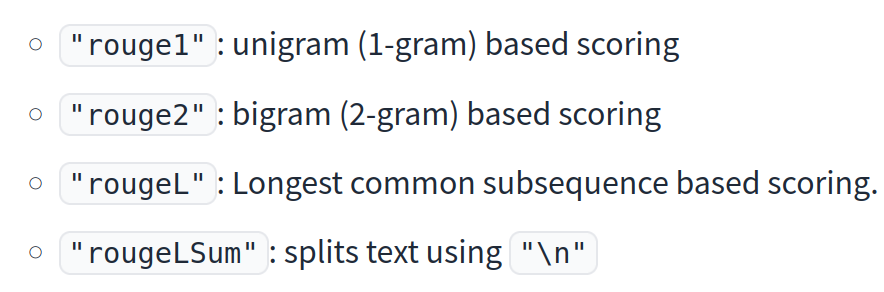

### References:
[1] Prakhar Mishra. 2020. Understanding T5 Model : Text to Text Transfer Transformer Model. Towards Data Science
https://towardsdatascience.com/understanding-t5-model-text-to-text-transfer-transformer-model-69ce4c165023.

[2] Summarization. Huggingface. https://huggingface.co/docs/transformers/tasks/summarization.

[3] Fabio Chiusano. 2022. Two minutes NLP — Learn the ROUGE metric by examples. Medium. https://medium.com/nlplanet/two-minutes-nlp-learn-the-rouge-metric-by-examples-f179cc285499.